# Model

In this notebook we read in the previously created dataset with features engineered, and then perform the following tasks:
    
    * Split into train and test data. Also use reduced size subsets for quicker evaluation.
    * Evaluate some classification algorithms and paramters.
    * Perform simple cross validation to find the best model.
    * Measure the model performance.

## Read in dataset and verify

In [1]:
# Imports
import findspark
findspark.init()
findspark.find()
import pyspark

In [2]:
# Imports for creating spark session
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('sparkify-capstone-model').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
# Imports for modelling, tuning and evaluation
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [4]:
# Imports for visualization and output
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [5]:
# Read in dataset
conf.set("spark.driver.maxResultSize",  "0")
path = "out/features.parquet"
df = spark.read.parquet(path)

In [6]:
# Look at some values about the data to confirm it was read in correctly
print("Dataset set rows/cols: {},{}".format(df.count(), len(df.columns)))

Dataset set rows/cols: 528005,2


In [7]:
df.printSchema()
df.show(10)

root
 |-- features: vector (nullable = true)
 |-- churn: integer (nullable = true)

+--------------------+-----+
|            features|churn|
+--------------------+-----+
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
|[0.0,0.0,90.0,12....|    0|
+--------------------+-----+
only showing top 10 rows



## Split

Try three ways to split the data to have an initial idea about how some algorithms perform.

In [8]:
# First, we are going to use just a subset of the dataset becuase doing a lot of tuning and cross validation 
# would take too long otherwise.
def createSubset(df, factor):
    """
    INPUT:
        df: The dataset to split
        factor: How much of the dataset to return
    OUTPUT: 
        df_subset: The split subset
    """
    df_subset, df_dummy = df.randomSplit([factor, 1 - factor])
    return df_subset

df_subset = createSubset(df, .2)
df_subset.count()

105582

In [9]:
# Now we split the subset into train and test. 
# Note: Best split factor of 90% was determined by trial and error.
df_train, df_test = df_subset.randomSplit([0.9, 0.1])
print(df_train.count())
print(df_test.count())

94867
10715


## Algorithm selection

We will be looking at some of pysparks classificatoin algorhtims:

    * Logistic Regression (single)
    * Random Forest (parallel)
    * Gradient-Boosted Tree (sequential)
    
The most basic, logistic regression is a good start.

### LogisticRegression

First we will be creating a function to fit and train the LR model, which we may use many times.
Then we also create some helpful functions for showing the evaluation of the model with some metrics.

In [10]:
def logisticRegressionPredictions(df_train, df_test, threshold = 0.5, labelCol = "churn", featuresCol = "features"):
    """ Fit, evaluate and show results for LogisticRegression 
    INPUT:
        df_train: The training data set
        df_test: The testing data set
        threshold: The algorithm's threshold for classification.
        labelCol: The label column name, "churn" by default.
        featuresCol: The label column name, "features" by default.
    OUTPUT:
        predictions: The model's predictions
    """
    # Fit and train model
    logreg = LogisticRegression(labelCol = labelCol, featuresCol = featuresCol, threshold = threshold).fit(df_train)
    return logreg.evaluate(df_test).predictions

def printConfusionMatrix(tp, fp, tn, fn):
    """ Simple function to output a confusion matrix from f/t/n/p values as html table.
    INPUT:
        data: The array to print as table
    OUTPUT:
        Prints the array as html table.
    """
    html = "<table><tr><td></td><td>Act. True</td><td>False</td></tr>"
    html += "<tr><td>Pred. Pos.</td><td>{}</td><td>{}</td></tr>".format(tp, fp)
    html += "<tr><td>Negative</td><td>{}</td><td>{}</td></tr>".format(fn, tn)    
    html += "</table>"
    display(HTML(html))    
    
def showEvaluationMetrics(predictions):
    """ Calculate and print the some evaluation metrics for the passed predictions.
    INPUT:
        predictions: The predictions to evaluate and print
    OUTPUT:
        Just prints the evaluation metrics
    """
    # Calculate true, false positives and negatives to calculate further metrics later:
    tp = predictions[(predictions.churn == 1) & (predictions.prediction == 1)].count()
    tn = predictions[(predictions.churn == 0) & (predictions.prediction == 0)].count()
    fp = predictions[(predictions.churn == 0) & (predictions.prediction == 1)].count()
    fn = predictions[(predictions.churn == 1) & (predictions.prediction == 0)].count()
    
    printConfusionMatrix(tp, fp, tn, fn)
    
    # Calculate and print metrics
    f1 = MulticlassClassificationEvaluator(labelCol = "churn", metricName = "f1") \
        .evaluate(predictions)
    accuracy = float((tp + tn) / (tp + tn + fp + fn))
    recall = float(tp / (tp + fn))
    precision = float(tp / (tp + fp))
    print("F1: ", f1) 
    print("Accuracy: ", accuracy) 
    print("Recall: ", recall)
    print("Precision: ", precision) 
    
def plotROC(df_model):
    """
    Plot the Receiver Operator Curve for the evaluated model
    INPUT:
        df_model: The trained model
    OUTPUT:
        Plots the curve
    """
    plt.figure(figsize = (5,5))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(df_model.summary.roc.select('FPR').collect(),
             df_model.summary.roc.select('TPR').collect())
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()    
    
def printAUC(predictions, labelCol = "churn"):
    """ Print the area under curve for the predictions.
    INPUT: 
        predictions: The predictions to get and print the AUC for
    OUTPU:
        Prints the AUC
    """
    print("Area under curve: ", BinaryClassificationEvaluator(labelCol = labelCol).evaluate(predictions))

In [11]:
predictions = logisticRegressionPredictions(df_train, df_test)    
showEvaluationMetrics(predictions)  

,Act. True,False
Pred. Pos.,236,107
Negative,1845,8527


F1:  0.7608456698702306
Accuracy:  0.8178254783014466
Recall:  0.1134070158577607
Precision:  0.6880466472303207


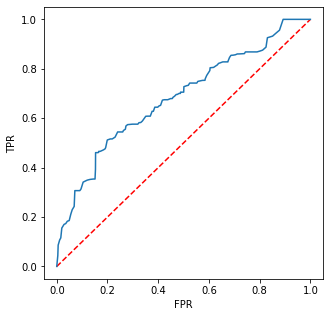

Area under curve:  0.6775022076149889


In [12]:
# Evaluation results:

# The confusion matrix looks pretty good but a bit worrying is the high count of false negatives (Type 2 errors).
# This is possibly due to our label set being unbalanced.

# F1 score is looking good, I can be happy with over 80% at first try.
# But as expected, the high false negative count lead to a bad recall score.
# In the case of churn, a false negative is not a desirable prediction outcome, because this means we miss customers
# who actually churn and do not get a chance to change their minds. Which is the point of the excersize.
# So we will try to tune this and also watch the overall score.

# But before, let's plot the ROC and show AUC:

model = LogisticRegression(labelCol = "churn").fit(df_train)
model.evaluate(df_test).predictions

plotROC(model)
printAUC(predictions)

In [13]:
# This looks like a lot of RO curves I have seen so that and also high AUC seems promising as well.
# Lookig the the curve though, we see there is some room for improvement.

### Optimization: Threshold

Since our input data is skewed on the label, we can try to undersample negative cases by lowering the threshold.
Hopefully, this will help significantly with our bad recall rate.

In [14]:
predictions = logisticRegressionPredictions(df_train, df_test, 0.4)    
showEvaluationMetrics(predictions)  

,Act. True,False
Pred. Pos.,261,167
Negative,1820,8467


F1:  0.7615725199332655
Accuracy:  0.8145590293980401
Recall:  0.12542047092743874
Precision:  0.6098130841121495


In [15]:
# We see that our f1 score has slightly improved. Recall increased by quite a bit but precision also went down.
# Let's try one more time with an only slighty smaller threshold:
predictions = logisticRegressionPredictions(df_train, df_test, 0.45)    
showEvaluationMetrics(predictions)  

,Act. True,False
Pred. Pos.,236,131
Negative,1845,8503


F1:  0.7593514772947256
Accuracy:  0.815585627624825
Recall:  0.1134070158577607
Precision:  0.6430517711171662


In [16]:
# Recall went down and precision up.
# So there is a tradeoff here. Maybe if we change the input data itself? 

### Optimization: Undersampling negatives in the input data

As an alternative to penalize false negatives, we can try to undersample them.

In [17]:
# Check distributions of churn 
zeros = df_subset.filter(df["churn"] == 0)
ones = df_subset.filter(df["churn"] == 1)
zerosCount = zeros.count()
onesCount = ones.count()
print("Ones: {}, Zeros: {}".format(onesCount, zerosCount))
print(onesCount / zerosCount * 100)

Ones: 20658, Zeros: 84924
24.325279073053554


In [18]:
# As a "quick and dirty" check, we will just hack off some 0's and see what happens.
# Note: Normally we would use something like KStratified sampling or similar but that is beyond the scode of this project.
def undersampleNegatives(df, ratio, labelCol = "churn"):
    """
    Undersample the negatives (0's) in the given dataframe by ratio.
    
    NOTE: The "selection" method here is of course very crude and in a real version should be randomized and shuffled.
    
    INPUT:
        df: dataframe to undersample negatives from
        ratio: Undersampling ratio
        labelCol: LAbel column name in the input dataframe
    OUTPUT:
        A new dataframe with negatives undersampled by ratio
    """
    zeros = df.filter(df[labelCol] == 0)
    ones = df.filter(df[labelCol] == 1)
    zeros = createSubset(zeros, ratio)
    return zeros.union(ones)
                                
df_undersampled = undersampleNegatives(df_subset, .8)

In [19]:
# Check distribution again
zeros = df_undersampled.filter(df["churn"] == 0)
ones = df_undersampled.filter(df["churn"] == 1)
zerosCount = zeros.count()
onesCount = ones.count()
print("Ones: {}, Zeros: {}".format(onesCount, zerosCount))
print(onesCount / zerosCount * 100)

Ones: 20658, Zeros: 67911
30.41922516234483


In [20]:
df_train, df_test = df_undersampled.randomSplit([0.91, 0.09])
predictions = logisticRegressionPredictions(df_train, df_test)    
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,191,88
Negative,1632,6087


F1:  0.717912749515747
Accuracy:  0.7849462365591398
Recall:  0.1047723532638508
Precision:  0.6845878136200717
Area under curve:  0.6747464805310462


In [21]:
# As we can see, our recall score did go up a little, but at the cost of precision.
# Same as when we modified te threshold.
# The f1 score stayed about the same, but the AUC went up a little.
# 
# So while we do have some small optimization, it will be a business decision to decide which way to 
# tune the model - either more precision or more recall.
# Another thing we can try is to modify our input data in the ETL stage.

### RandomForest

Logistic regression performed reasonably well but there was a very low recall rate.
Let's see how a RandomForesClassifier does on this dataset.
Since we have some high correlation, an ensemble learning model
like RFC might do a little better.

In [22]:
def randomForestPredictions(df_train, df_test, numTrees = 50, labelCol = "churn", featuresCol = "features"):
    """ Fit, evaluate and show results for RandomForestClassifier 
    INPUT:
        df_train: The training data set.
        df_test: The testing data set.
        numTrees: Number of trees in the forest.
        labelCol: The label column name, "churn" by default.
        featuresCol: The label column name, "features" by default.
    OUTPUT:
        predictions: The model's predictions.
    """
    # Fit and train model
    rfc = RandomForestClassifier(labelCol = labelCol, featuresCol = featuresCol, numTrees = numTrees).fit(df_train)
    return rfc.transform(df_test)

predictions = randomForestPredictions(df_train, df_test)

In [23]:
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,304,0
Negative,1519,6175


F1:  0.7526614325181695
Accuracy:  0.810077519379845
Recall:  0.16675809105869446
Precision:  1.0
Area under curve:  0.9223249926157222


In [24]:
# While there is a very low recall rate, the Precision is perfect (This could be due to our reduced dataset size), 
# and the AUC is pretty high as well.
# Let's try another optimization.

### Optimization: numTrees

We will try to increase the number of decision trees in the forest.

In [25]:
predictions = randomForestPredictions(df_train, df_test, 100)
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,304,0
Negative,1519,6175


F1:  0.7526614325181695
Accuracy:  0.810077519379845
Recall:  0.16675809105869446
Precision:  1.0
Area under curve:  0.9212026268041512


In [26]:
# Not a whole lot has improved.
# Lastly we try to run the RF on the undersampled input data.
# Since it severly penalized the recall, we will remove a larger portion of negatives this time.

### Optimization: Undersampled negatives

Same as above with LogisticRegression.

In [27]:
# ratio was derived by trial and error
df_undersampled = undersampleNegatives(df_subset, .264)
df_train, df_test = df_undersampled.randomSplit([0.9, 0.1])
predictions = randomForestPredictions(df_train, df_test, 100)
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,1789,506
Negative,270,1782


F1:  0.8214704759112346
Accuracy:  0.8214860823556476
Recall:  0.8688683827100534
Precision:  0.779520697167756
Area under curve:  0.9296603560354167


In [28]:
# It seems that with severely reduced negatives in the data, the RandomForest classifier was able to converge better.
# The f1 score has worsened, but now recall is on a higher level, meaning we would not miss
# as many customers churning as before.
# But will these good results from the undersampled data hold for the real test data? Let's see:

rfc = RandomForestClassifier(labelCol = "churn", featuresCol = "features", numTrees = 100).fit(df_train)
df_train, df_test = df_subset.randomSplit([0.9, 0.1])
predictions = rfc.transform(df_test)
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,1851,1879
Negative,272,6747


F1:  0.8170823070494587
Accuracy:  0.7998883617080659
Recall:  0.8718794159208667
Precision:  0.49624664879356567
Area under curve:  0.9288822616591779


In [29]:
# Again we see that there is a tradeoff to be expected between recall and precision.
# But the f1 score is good, as is precision, and now recall is looking better, so it's an improvement.
# Anyway this concludes the preliminary experiments for RandomForest tuning, in conclusion I like the model better as it seems
# to perform better and also gives more leeway when tuning as compared to LogisticRegression.

### Gradient Boost

As last algorithm we try a gradient boosted tree classifier.

In [30]:
def gbtPredictions(df_train, df_test, maxIter = 10, labelCol = "churn", featuresCol = "features"):
    """ Fit, evaluate and show results for GBTClassifier 
    INPUT:
        df_train: The training data set.
        df_test: The testing data set.
        maxIter: Number of maximum iterations in the gradeint boost.
        labelCol: The label column name, "churn" by default.
        featuresCol: The label column name, "features" by default.
    OUTPUT:
        predictions: The model's predictions
    """
    # Fit and train model
    gbt = GBTClassifier(labelCol = labelCol, featuresCol = featuresCol, maxIter = maxIter).fit(df_train)
    return gbt.transform(df_test)

predictions = gbtPredictions(df_train, df_test)

In [31]:
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,1225,0
Negative,898,8626


F1:  0.9073201489745509
Accuracy:  0.9164573448692902
Recall:  0.5770136599152144
Precision:  1.0
Area under curve:  0.9912217813817268


In [32]:
# The GBT results look very promising. There are very high rates right off the bat, and recall is nearing 50%.

### Optimization: Unersampling negatives

With our experience from above, let's try undersampling as first optimization.

In [33]:
# What happens here is largeley analogous to similar procedures above.
df_undersampled = undersampleNegatives(df_subset, .6)
df_train, df_test = df_undersampled.randomSplit([0.9, 0.1])
predictions = gbtPredictions(df_train, df_test)
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,1500,14
Negative,589,5025


F1:  0.9109367889590346
Accuracy:  0.9154040404040404
Recall:  0.7180469123982767
Precision:  0.9907529722589168
Area under curve:  0.99112660833816


In [34]:
# This is a significant improvement. There is a strongly improved recall rate at a high precision.
# Let's see how it does on the normal sampled test set:

gbt = GBTClassifier(labelCol = "churn", featuresCol = "features", maxIter = 10).fit(df_train)
df_train, df_test = df_subset.randomSplit([0.9, 0.1])

predictions = gbt.transform(df_test)
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,1548,18
Negative,586,8422


F1:  0.9394240768846722
Accuracy:  0.9428787592207301
Recall:  0.725398313027179
Precision:  0.9885057471264368
Area under curve:  0.9919879617743863


In [35]:
# The model was able to translate it's performance very well to the normal sampled dataset. 
# I am convinced that this is the best algorithm to use. 

### Full undersampled dataset

Let us run and evalute the algorithm on the full (undersampled) dataset.

In [36]:
df_train, df_test = df.randomSplit([0.9, 0.1])
df_undersampled = undersampleNegatives(df_train, .6)

gbt = GBTClassifier(labelCol = "churn", featuresCol = "features", maxIter = 10).fit(df_undersampled)
predictions = gbt.transform(df_test)
                                 
showEvaluationMetrics(predictions)  
printAUC(predictions)

,Act. True,False
Pred. Pos.,7589,228
Negative,2766,42569


F1:  0.9405484467736669
Accuracy:  0.9436709813365443
Recall:  0.7328826653790439
Precision:  0.9708328003070231
Area under curve:  0.9891197861572065


In [37]:
# The f1 score is very good, in fact all scores but recall are very good.
# But recall is still very acceptable under these conditions.
# Now we can use automated optimization to search for the best GBT model.      

In [39]:
# Output the notebook to an html file
from subprocess import call
call(['python', '-m', 'nbconvert', 'model.ipynb'])

0